In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import seaborn as sns
from IPython.display import display, Math
import matplotlib.lines as mlines
import matplotlib.colors as mcolors

import sys
import os
sys.path.append(os.path.abspath('../utils'))
from Perturbe_Algs import Attacks


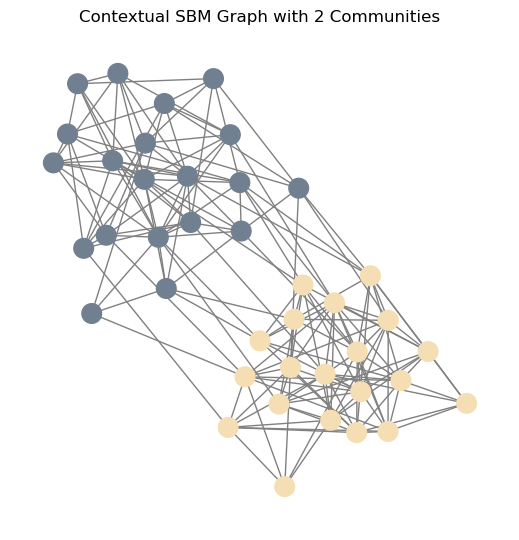

In [2]:
# Create a contextual stochastic block model (SBM) graph with two communities
n = [20,20] # Number of nodes in each community
N = np.sum(n)       
p_in = 0.4  
p_out = 0.05
p_matrix = np.full((2,2),p_out)
np.fill_diagonal(p_matrix,p_in)
# Greate SBM graph
G = nx.stochastic_block_model(n, p_matrix, seed=1)
for u in range(N):
        if u< n[1]:
            G.nodes[u]['label'] = 1
        else:
            G.nodes[u]['label'] = -1
# Create node feature x_i = \pm c + N(0,1)
d = 100
for u in G.nodes():
    G.nodes[u]['feature'] =  2*G.nodes[u]['label'] + np.random.normal(0, 1,d)


# Visualize result
colors = ['#F5DEB3', '#708090']
cmap = mcolors.ListedColormap(colors)
plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=1)  # Layout for visualization
node_colors = [G.nodes[node]['label'] for node in G.nodes()]  # Color by label
nx.draw(G, pos, node_color=node_colors, cmap=cmap, node_size=200, edge_color='gray', with_labels=False, alpha =1)
plt.title("Contextual SBM Graph with 2 Communities")
plt.show()

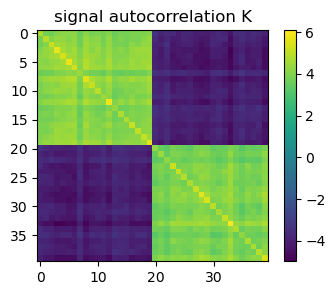

In [3]:
# (1) Compute the signal autocorrelation matrix K
# K = 1/N \sum_{i=1}^N x_i x_i^T
X = np.zeros((N,d))
for u in range(N):
        X[u,:] =  G.nodes[u]['feature']

K_cSBM = X@X.T/d

plt.figure(figsize = (4,3))
plt.imshow(K_cSBM,interpolation='None')
plt.colorbar()
plt.title('signal autocorrelation K')
plt.show()


In [4]:
# Set up parameters for the attack
m = 20
J = np.ones((N,N))
I = np.eye(N)
A_SBM = nx.adjacency_matrix(G).todense()

A = torch.tensor(A_SBM).type(torch.double)
n = A.shape[0]
K = torch.tensor(K_cSBM).type(torch.double)
X = torch.tensor(X).type(torch.double)
Knp = K.cpu().numpy()


print(f'Perturbe {m: d} edges')
alpha = 1
max_iter = 100
mute = True


Perturbe  20 edges


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Adverarial edge perturbation on the adjacency matrix
Attack_adj = Attacks(A, K, m, alpha, max_iter,filter = 'adj').to(device)
A_pgd_wst = Attack_adj.Wst_PGD()
A_random = Attack_adj.randomAttack()
A_pgd_avg = Attack_adj.Prob_PGD()

# Adverarial edge perturbation on the graph Laplacian matrix
Attack_lap = Attacks(A, K, m, alpha, max_iter,filter = 'lap').to(device)
A_pgd_avg_L = Attack_lap.pgd_avg()



Using device: cpu


In [6]:
def plot_perturbed_graph(A_original, A_modified, G, pos, title):
    diff_matrix = A_modified - A_original
    # Create a list to store edges to be highlighted
    edges_to_highlight = []
    for i in range(diff_matrix.shape[0]):
        for j in range(i + 1, diff_matrix.shape[1]):  # Iterate over upper triangle
            if diff_matrix[i, j] == 1:  # Added edge
                edges_to_highlight.append((i, j, 'added'))
            elif diff_matrix[i, j] == -1:  # Deleted edge
                edges_to_highlight.append((i, j, 'deleted'))

    # Visualize the graph with highlighted edges
    plt.figure(figsize=(5, 5))
    node_colors = [G.nodes[node]['label'] for node in G.nodes()]
    nx.draw(G, pos, node_color=node_colors, cmap=cmap, node_size=250, edge_color='gray', with_labels=False)
   
    # Highlight modified edges
    for u, v, edge_type in edges_to_highlight:
        if edge_type == 'added':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#8FBC8F', width=3.5)
        elif edge_type == 'deleted':
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color='#B22222', style=':', width=3.5)

    added_edge_line = mlines.Line2D([], [], color='#8FBC8F', label='Added Edge', linestyle='-')
    deleted_edge_line = mlines.Line2D([], [], color='#B22222', label='Deleted Edge', linestyle=':')
    plt.legend(handles=[added_edge_line, deleted_edge_line])
    plt.axis('off')
    # plt.tight_layout()
    plt.title(title)
    plt.show()
# Plot perturbed graphs

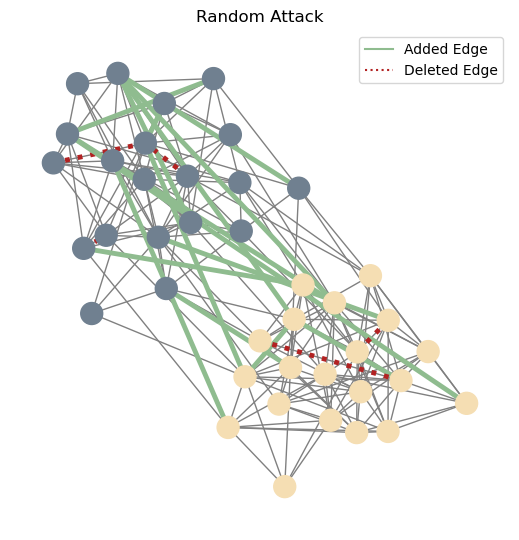

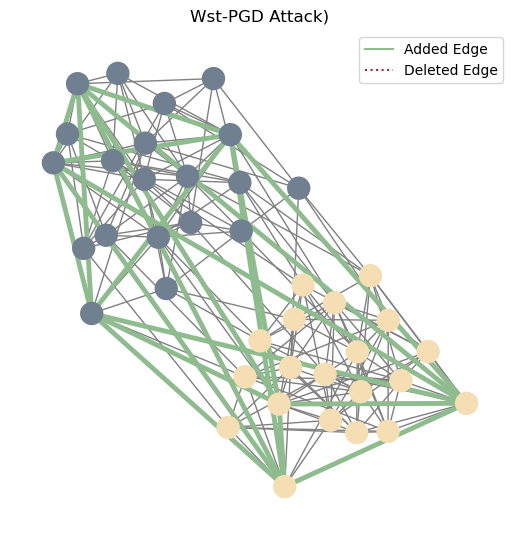

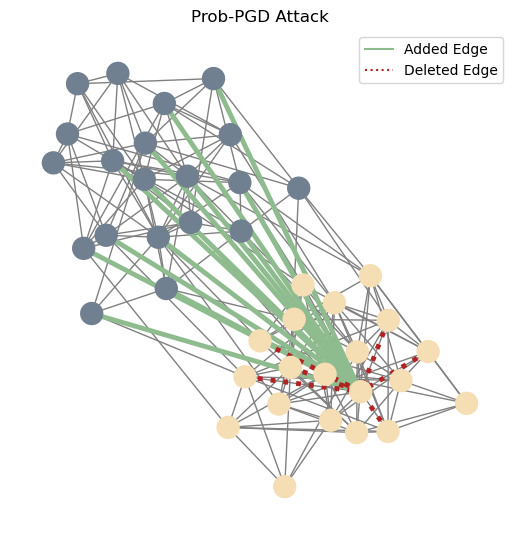

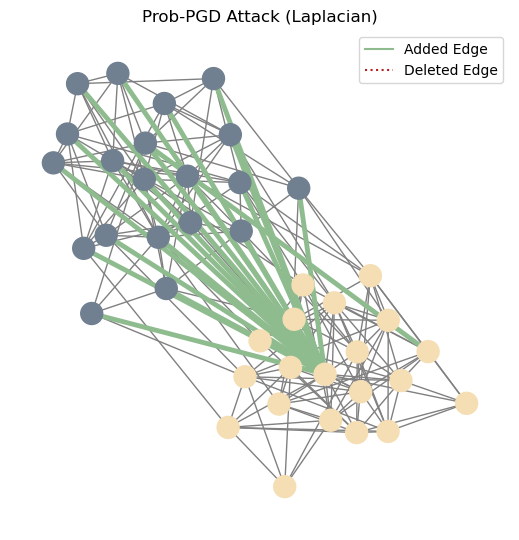

In [7]:
plot_perturbed_graph(A_SBM, A_random, G, pos, title = 'Random Attack')
plot_perturbed_graph(A_SBM, A_pgd_wst, G, pos, title = 'Wst-PGD Attack)')
plot_perturbed_graph(A_SBM, A_pgd_avg, G, pos, title = 'Prob-PGD Attack')
plot_perturbed_graph(A_SBM, A_pgd_avg_L, G, pos, title = 'Prob-PGD Attack (Laplacian)')

In [9]:
#  Emeprical embedding perturbations for each graph signal
A_delta_x_random = np.zeros(d)
A_delta_x_structure = np.zeros(d)
A_delta_x_L = np.zeros(d)
for j in range(d):
  A_delta_x_random[j] = torch.norm(((A-A_random) ) @ X[:,j], p ='fro').item()
  A_delta_x_structure[j] = torch.norm(((A-A_pgd_avg) ) @ X[:,j], p ='fro').item()
  A_delta_x_L[j] = torch.norm(((A-A_pgd_avg_L) ) @ X[:,j], p ='fro').item()


L = torch.diag(torch.sum(A,axis = 1)) - A
L_random = torch.diag(torch.sum(A_random,axis = 1)) - A_random
L_pgd_avg = torch.diag(torch.sum(A_pgd_avg, axis = 1)) - A_pgd_avg
L_pgd_avg_L = torch.diag(torch.sum(A_pgd_avg_L, axis = 1)) - A_pgd_avg_L


L_delta_x_random = np.zeros(d)
L_delta_x_structure = np.zeros(d)
L_delta_x_L = np.zeros(d)
for j in range(d):
  L_delta_x_random[j] = torch.norm(((L-L_random) ) @ X[:,j], p ='fro').item()
  L_delta_x_structure[j] = torch.norm(((L-L_pgd_avg) ) @ X[:,j], p ='fro').item()
  L_delta_x_L[j] = torch.norm(((L-L_pgd_avg_L) ) @ X[:,j], p ='fro').item()



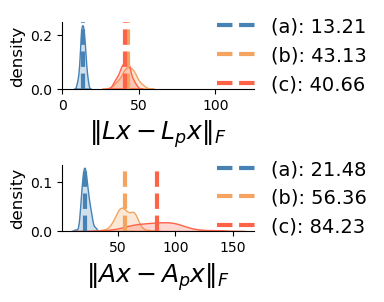

In [10]:
import seaborn as sns


# Create the grouped density plot
plt.figure(figsize=(4, 3))
plt.subplot(2, 1, 1)
sns.kdeplot(A_delta_x_random, fill=True,color = 'SteelBlue')
plt.axvline(np.mean(A_delta_x_random), color='SteelBlue', linestyle='--', label=f'(a): {np.mean(A_delta_x_random):.2f}', linewidth = 3)

sns.kdeplot(A_delta_x_structure, fill=True,color = '#F4A460')
plt.axvline(np.mean(A_delta_x_structure), color='#F4A460', linestyle='--', label=f'(b): {np.mean(A_delta_x_structure):.2f}', linewidth = 3)

sns.kdeplot(A_delta_x_L, fill=True,color = '#FF6347')
plt.axvline(np.mean(A_delta_x_L), color='#FF6347', linestyle='--', label=f'(c): {np.mean(A_delta_x_L):.2f}', linewidth = 3)

plt.xlabel(f"$\|Lx-L_px\|_F$",fontsize = 18)
# plt.xlabel(f"embedding perturbation of A",fontsize = 12)
plt.ylabel("density", fontsize = 12)

plt.xlim(0,125)
plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', fontsize = 14,frameon=False)  # or loc='upper left', 'lower left', etc.
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()

plt.subplot(2, 1, 2)
sns.kdeplot(L_delta_x_random, fill=True,color = 'SteelBlue')
plt.axvline(np.mean(L_delta_x_random), color='SteelBlue', linestyle='--', label=f'(a): {np.mean(L_delta_x_random):.2f}', linewidth = 3)

sns.kdeplot(L_delta_x_structure, fill=True,color = '#F4A460')
plt.axvline(np.mean(L_delta_x_structure), color='#F4A460', linestyle='--', label=f'(b): {np.mean(L_delta_x_structure):.2f}', linewidth = 3)

sns.kdeplot(L_delta_x_L, fill=True,color = '#FF6347')
plt.axvline(np.mean(L_delta_x_L), color='#FF6347', linestyle='--', label=f'(c): {np.mean(L_delta_x_L):.2f}', linewidth = 3)

plt.xlabel(f"$\|Ax-A_px\|_F$",fontsize = 18)
# plt.xlabel(f"embedding perturbation of A",fontsize = 12)
plt.ylabel("density", fontsize = 12)


plt.legend(bbox_to_anchor=(1.2, 0.5), loc='center', fontsize = 14,frameon=False)  # or loc='upper left', 'lower left', etc.
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()
